## Unsupervised learning

In [89]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler


### Funções

In [90]:
def information_data (data):
       
    len_array = []
    for var in data.columns:
        current_len  = len(data[var].unique())
        len_array.append(current_len)

    missing = pd.DataFrame(np.array(data.isnull().sum()), columns = ['missing'])
    p_missing = missing / data.shape[0]
    types = pd.DataFrame( np.array(data.dtypes), columns=['type'])

    qtd = pd.concat([pd.DataFrame(data.columns), types.type, missing.missing, pd.DataFrame(p_missing),  pd.DataFrame(len_array)], axis = 1)
    qtd.columns = ['var', 'type', '# missing','% missing', '# unique values']
    
    print 'Data with', data.shape[0], 'samples and ', data.shape[1], 'features'
    print '\n'
    print 'Data with', qtd[qtd['# missing'] > 0].shape[0], 'columns with missings'
    print '\n'
    
    return qtd


def fit_transform_with_function (data, function, sklearn):
    scaler = function
    
    if sklearn == 'True':
        scaler = function
        data_transformed = scaler.fit_transform(data)
        data_transformed2 = pd.DataFrame(data_transformed, columns = data.columns, index = data.index)
        
    else:
        data_transformed2 = data.apply(function)
        
    return scaler, data_transformed2

#X_train.apply(standard_scaler_manual)


def transform_with_function (data, scaler, sklearn):
    
    if sklearn == 'True':
        data_transformed = scaler.transform(data)
        data_transformed2 = pd.DataFrame(data_transformed, columns = data.columns, index = data.index)
    
    else:
        data_transformed2 = data.apply(scaler)
    
        
    
    return data_transformed2

## Hierárquico

#### 1. importa base

essa tem target -> não é o padrão

In [91]:
from sklearn.datasets import load_iris
iris = load_iris()
data = pd.DataFrame(iris.data)
data.columns = iris.feature_names
data['target']  = iris.target
print information_data(data)
data.head()

Data with 150 samples and  5 features


Data with 0 columns with missings


                 var     type  # missing  % missing  # unique values
0  sepal length (cm)  float64          0        0.0               35
1   sepal width (cm)  float64          0        0.0               23
2  petal length (cm)  float64          0        0.0               43
3   petal width (cm)  float64          0        0.0               22
4             target    int32          0        0.0                3


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [92]:
#DBSCAN nao tem predict então será usada toda a base
Y = data.iloc[:, 4]
data.drop(['target'], axis = 1, inplace=True)
X = data.copy()
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


#### 2. padroniza base

In [93]:
scaler, data_norm = fit_transform_with_function(X, StandardScaler(), 'True')
data_norm.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977


#### 3. aplica PCA

In [103]:
pca = PCA(n_components=2)
pc = pca.fit_transform(data_norm)
data_norm_pca = pd.DataFrame(data = pc, columns = ['PC 1', 'PC 2'])
data_norm_pca_target = pd.concat([data_norm_pca, Y], axis = 1)
data_norm_target = pd.concat([data_norm, Y], axis = 1)

print "Percentual da variância explicada:", pca.explained_variance_ratio_ 
data_norm_pca_target.head()

Percentual da variância explicada: [ 0.72770452  0.23030523]


,PC 1,PC 2,target
0,-2.264542,0.505704,0
1,-2.086426,-0.655405,0
2,-2.367950,-0.318477,0
3,-2.304197,-0.575368,0
4,-2.388777,0.674767,0


visualizando PCA com a target

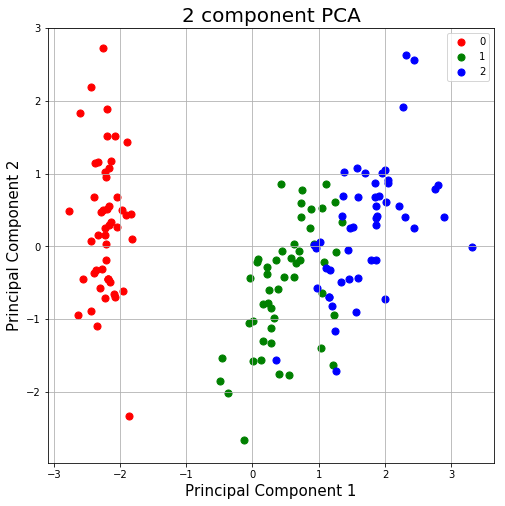

In [95]:
def plot_PCA_groups (data, group):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    #targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

    targets = [0 ,1 ,2]
    colors = ['r', 'g', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = data[group] == target
        ax.scatter(data.loc[indicesToKeep, 'PC 1']
                   , data.loc[indicesToKeep, 'PC 2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    return fig

plot_PCA_groups(data_norm_pca_target, 'target')

#### 4. aplica método - fit da função

O cluster hierárquico foi aplicado na base com PCA *data_norm_pca*, mas poderia aplicado na *data_norm*, basta trocar os nomes

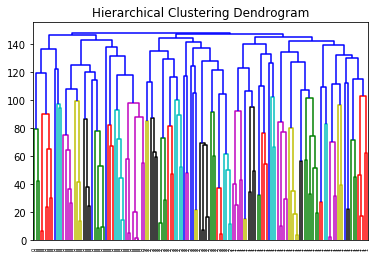

In [98]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_
    #print(children)
    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])
    #print distance
    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


#iris = load_iris()
#x = data_norm
model = AgglomerativeClustering(n_clusters=3,linkage='ward')

#model = model.fit(data_norm_pca)
clusters_labels = model.fit_predict(data_norm_pca)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, labels=clusters_labels)
plt.show()


In [99]:
n_clusters = max(clusters_labels) - min(clusters_labels) + 1
print 'quantidade de clusters total:', n_clusters

quantidade de clusters total: 3


Visualização com PCA

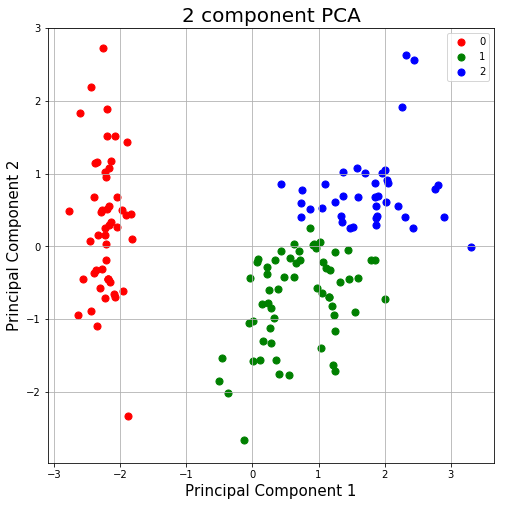

In [100]:
previsoes = pd.concat([data_norm_pca_target, pd.DataFrame(clusters_labels)], axis = 1)
previsoes.columns = ['PC 1', 'PC 2', 'target', 'clusters_hierarq']
previsoes
def plot_PCA_groups (data, group):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    #targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

    targets = [0 ,1 ,2]
    colors = ['r', 'g', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = data[group] == target
        ax.scatter(data.loc[indicesToKeep, 'PC 1']
                   , data.loc[indicesToKeep, 'PC 2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    return fig

plot_PCA_groups(previsoes, 'clusters_hierarq')

In [101]:
previsoes.head()

,PC 1,PC 2,target,clusters_hierarq
0,-2.264542,0.505704,0,0
1,-2.086426,-0.655405,0,0
2,-2.367950,-0.318477,0,0
3,-2.304197,-0.575368,0,0
4,-2.388777,0.674767,0,0


In [102]:
pd.crosstab(previsoes.target,previsoes.clusters_hierarq)

clusters_hierarq,0,1,2
target,,,
0,50,0,0
1,0,41,9
2,0,20,30


#### 5. centroides; wcss; silhueta manual

Silhueta

In [85]:
silhueta = silhouette_score(data_norm_pca,  clusters_labels)
print 'Silhueta:', silhueta

Silhueta: 0.510294444177


"Centroides"

In [86]:
df_total = pd.concat([data_norm_pca, pd.DataFrame(clusters_labels, columns = ['label'])], axis = 1)
centroides_m = df_total.groupby(by = ['label']).mean()
print centroides_m
df_total.head()

           PC 1      PC 2
label                    
0     -2.220193  0.292225
1      0.686750 -0.723823
2      1.772255  0.757487


,PC 1,PC 2,label
0,-2.264542,0.505704,0
1,-2.086426,-0.655405,0
2,-2.367950,-0.318477,0
3,-2.304197,-0.575368,0
4,-2.388777,0.674767,0


WCSS

In [88]:
a = []
first=True
for k in [0,1,2]:
    print k
    df_total2 = df_total[df_total.label == k]
    aux = euclidean_distances(df_total2.iloc[:,0:(df_total2.shape[1]-1)], centroides_m[centroides_m.index == k])**2
    aux = pd.DataFrame(aux)
    print 'wcss no cluster k =', k , ':', aux.sum()
    #print(aux)
    if first == True:
        a=pd.DataFrame(aux)
        first = False
    else:
        a = pd.concat([a, aux], axis = 0)
    
    
    #a.append(aux)
#print(a)
wcss_m = np.float(a.sum())
print '\nWCSS:', wcss_m

0
wcss no cluster k = 0 : 0    45.636142
dtype: float64
1
wcss no cluster k = 1 : 0    45.671027
dtype: float64
2
wcss no cluster k = 2 : 0    27.165492
dtype: float64

WCSS: 118.472660276
